In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
# from torchvision.datasets import STL10
import torchvision.datasets as datasets
from matplotlib import pyplot as plt

C:\Users\ben\AppData\Roaming\Python\Python37\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
# Displaying routine
def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 96, 96)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 96, 96)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

In [3]:
# Set random seeds

torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [4]:
# Define data loading step

normalize = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5032, 0.4746, 0.4275),(0.2268, 0.2225, 0.2256))])

batch_size = 256

kwargs = {'num_workers': 1, 'pin_memory': True}

unsup_data = datasets.ImageFolder('data/unsupervised/', transform=normalize)
train_loader = torch.utils.data.DataLoader(
        unsup_data,
        batch_size=batch_size,
        shuffle=True,
        **kwargs
    )

sup_val_data = datasets.ImageFolder('data/supervised/val', transform=normalize)
test_loader = torch.utils.data.DataLoader(
    sup_val_data,
    batch_size=batch_size,
    shuffle=True,
    **kwargs
)

# train_loader = torch.utils.data.DataLoader(
#     STL10('./data', download=True, transform = transforms.ToTensor()),
# #                    transform=transforms.Compose(
# #                        [transforms.Resize((96,96)),transforms.ToPILImage(mode='RGB'), transforms.ToTensor()])),
#     batch_size=batch_size, shuffle=True, **kwargs)
# test_loader = torch.utils.data.DataLoader(STL10('./data', transform=transforms.ToTensor()),
# #                                                 transform=transforms.Compose([transforms.Resize((96,96)),transforms.ToPILImage(mode='RGB'),transforms.ToTensor()])),
#     batch_size=batch_size, shuffle=True, **kwargs)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))
    
    def forward(self, x):
        return self.conv(x)


class DeConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DeConvBlock, self).__init__()

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))
    
    def forward(self, x):
        return self.deconv(x)

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.add_module('conv1', ConvBlock(64, 64))
        self.add_module('maxpool1', nn.MaxPool2d(kernel_size=4, return_indices=True))
        # (64)3c-3p-
        self.add_module('conv2', ConvBlock(64, 128))
        self.add_module('maxpool2', nn.MaxPool2d(kernel_size=3, return_indices=True))
        # (128)3c-
        self.add_module('conv3', ConvBlock(128, 128))
        # (128)3c-2p-
        self.add_module('conv4', ConvBlock(128, 256))
        self.add_module('maxpool3', nn.MaxPool2d(kernel_size=2, return_indices=True))
        # (256)3c-
        self.add_module('conv5', ConvBlock(256, 256))
        # (256)3c-
        self.add_module('conv6', ConvBlock(256, 512))
        # (256)3c-
        self.add_module('conv7', ConvBlock(512, 512))
        # (512)3c-
        self.add_module('conv8', ConvBlock(512, 512))
        # (512)3c-
        # 'conv9', ConvBlock(512, 10))
        self.add_module('maxpool4', nn.MaxPool2d(kernel_size=2, return_indices=True))
        # (512)3c-2p-10fc 
        self.add_module('fc1', nn.Linear(2048, 10))
        
        # )
        
        

    def forward(self, x):
        x = self._modules['conv1'](x)
        x, indices1 = self._modules['maxpool1'](x)
        x = self._modules['conv2'](x)
        x, indices2 = self._modules['maxpool2'](x)
        x = self._modules['conv3'](x)
        x = self._modules['conv4'](x)
        x, indices3 = self._modules['maxpool3'](x)
        x = self._modules['conv5'](x)
        x = self._modules['conv6'](x)
        x = self._modules['conv7'](x)
        x = self._modules['conv8'](x)
        # x = self['conv9'](x)
        x, indices4 = self._modules['maxpool4'](x)
#         print(x.shape)
        x = x.view(x.size(0), -1)
        x = self._modules['fc1'](x)
        return x, indices1, indices2, indices3, indices4

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        # self.add_module(# (512)3c-2p-10fc 
            # 'fc1', nn.Linear(num_classes, 10))
            # (512)3c-
        self.add_module('fc1', nn.Linear(10, 2048))
        self.add_module('unpool1', nn.MaxUnpool2d(kernel_size=2))
        self.add_module('deconv1', DeConvBlock(512, 512))
        # (512)3c-
        self.add_module('deconv2', DeConvBlock(512, 512))
        # (256)3c-
        self.add_module('deconv3', DeConvBlock(512, 512))
        # (256)3c-
        self.add_module('deconv4', DeConvBlock(512, 256))
        # (256)3c-
        self.add_module('deconv5', DeConvBlock(256, 256))
        # (128)3c-2p-
        self.add_module('unpool2', nn.MaxUnpool2d(kernel_size=2))
        self.add_module('deconv6', DeConvBlock(256, 128))
        
        # (128)3c-
        self.add_module('deconv7', DeConvBlock(128, 128))
        # (64)3c-3p-
        self.add_module('deconv8', DeConvBlock(128, 64))
        self.add_module('unpool3', nn.MaxUnpool2d(kernel_size=3))
        # (64)3c-4p-
        self.add_module('deconv9', DeConvBlock(64, 64))
        self.add_module('unpool4', nn.MaxUnpool2d(kernel_size=4))

    def forward(self, x, indices1, indices2, indices3, indices4):
        x = self._modules['fc1'](x)
#         print(x.shape)
        x = x.reshape(-1, 512, 2,2)
        x = self._modules['unpool1'](x, indices4)
        x = self._modules['deconv1'](x)
        x = self._modules['deconv2'](x)
        x = self._modules['deconv3'](x)
        x = self._modules['deconv4'](x)
        x = self._modules['deconv5'](x)
        x = self._modules['unpool2'](x, indices3)
        x = self._modules['deconv6'](x)
        
        x = self._modules['deconv7'](x)
        x = self._modules['unpool3'](x, indices2)
        x = self._modules['deconv8'](x)
        x = self._modules['unpool4'](x, indices1)
        x = self._modules['deconv9'](x)
#         print('decoder.forward output:', x.shape)
        return x

class VariationalAutoEncoder(nn.Module):
    def __init__(self, num_classes=1000):
        super(VariationalAutoEncoder, self).__init__()

        # self.encoder = nn.Sequential(
        self.conv0 = nn.Conv2d(3, 64, kernel_size=1)
        self.encoder = Encoder()
        self.decoder = Decoder()

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(64, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )
        
        self.convFinal = nn.Conv2d(64, 3, kernel_size=1)
    
    def saveEncoder(self, path):
        torch.save(self.encoder.state_dict(), path)
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        x = self.conv0(x)
        
        mu_logvar, indices1, indices2, indices3, indices4 = self.encoder(x)
        
#         print(mu_logvar.shape)
        
        mu_logvar = mu_logvar.view(-1, 2, 10)
#         # mu_logvar = self.encoder(x.view(-1, 1000)).view(-1, 2, d)
    
#         print(mu_logvar.shape)
    
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        
        z = self.reparameterize(mu, logvar)
        z = self.decoder(mu_logvar, indices1, indices2, indices3, indices4)

#         z = self.avgpool(z)
#         z = z.view(z.size(0), -1)
#         z = self.classifier(z)

#         return z, mu, logvar

        z = self.convFinal(z)
        return z, mu, logvar
    
    @staticmethod
    def loss_function(x_hat, x, mu, logvar):
        BCE = nn.functional.binary_cross_entropy(
            x_hat, x.view(-1, dataset_resolution), reduction='sum'
        )
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        
        return BCE + KLD

In [8]:
# encoder = Encoder()
# encoder.eval()

In [9]:
# decoder = Decoder()
# decoder.eval()

In [10]:
class VAEClassifier(nn.Module):
    def __init__(self, num_classes=1000):
        super(VAEClassifier, self).__init__()
        self.conv0 = nn.Conv2d(3, 64, kernel_size=1)
        self.encoder = Encoder()
        self.num_classes = num_classes

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(64, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )

        self.convFinal = nn.Conv2d(64, 3, kernel_size=1)
    
    #todo, load encoder weights
    def load(self, path):
        pass
    
    # this will need debugging
    def forward(self, x):
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x

In [11]:
# vae_classifier = VAEClassifier()
# vae_classifier.eval()

In [12]:
d = 20
num_classes = 1000
# 28 * 28 for MNIST
dataset_resolution = 96 * 96
        

# class VAE(nn.Module):
#     def __init__(self):
#         super().__init__()
        
#         self.encoder = nn.Sequential(
#             nn.Linear(dataset_resolution, d ** 2),
#             nn.ReLU(),
#             nn.Linear(d ** 2, d ** 2),
#             nn.ReLU(),
#             nn.Linear(d ** 2, d * 2)
#         )

#         self.decoder = nn.Sequential(
#             nn.Linear(d, d ** 2),
#             nn.ReLU(),
#             nn.Linear(d ** 2, d ** 2),
#             nn.ReLU(),
#             nn.Linear(d ** 2, dataset_resolution),
#             nn.Sigmoid(),
#         )
    
#     def reparameterise(self, mu, logvar):
#         if self.training:
#             std = logvar.mul(0.5).exp_()
#             eps = std.data.new(std.size()).normal_()
#             return eps.mul(std).add_(mu)
#         else:
#             return mu

#     def forward(self, x):
#         mu_logvar = self.encoder(x.view(-1, dataset_resolution)).view(-1, 2, d)
#         mu = mu_logvar[:, 0, :]
#         logvar = mu_logvar[:, 1, :]
#         z = self.reparameterise(mu, logvar)
#         z = self.decoder(z)
# #         z = self.avgpool(z)
# #         z = z.view(z.size(0), -1)
#         return z, mu, logvar
# #         return self.classifier(z), mu, logvar



# model = VAE().to(device)
model = VariationalAutoEncoder(num_classes).to(device)

In [13]:
path = "vae.pth"
# model.load_state_dict(torch.load(path))
# model.eval()

In [14]:
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [15]:
# Reconstruction + KL divergence losses summed over all elements and batch

def loss_function(x_hat, x, mu, logvar):
#     BCE = nn.functional.binary_cross_entropy(
#         x_hat, x.view(-1, dataset_resolution), reduction='sum'
#     )
    BCE = nn.functional.mse_loss(
        x_hat, x, reduction='sum'
    )
    
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + KLD

# def loss_function(x_hat, x):
#     return torch.sum(x_hat.pow(2))
#     return nn.functional.mse_loss(x)
#      return nn.functional.binary_cross_entropy(
#         x_hat, x.view(-1, dataset_resolution), reduction='sum'
#      )

In [16]:
# Training and testing the VAE
epochs = 100
for epoch in range(1, epochs + 1):
    # Training
    model.train()
    train_loss = 0
    for x, _ in train_loader:
#         print(x)
#         break
        x = x.to(device)
        # ===================forward=====================
        x_hat, mu, logvar = model(x)
#         print('x_hat', x_hat.shape)
#         print('x', x.shape)
#         print('mu', mu.shape)
#         print('logvar', logvar.shape)
#         x_hat = model(x)
        loss = loss_function(x_hat, x, mu, logvar)
#         loss = loss_function(x_hat, x)
#         print(loss.item())
        train_loss += loss.item()
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
    # Testing
    
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, _ in test_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
    # ===================log========================
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(x, x_hat, 1, f'Epoch {epoch}')

11802535.0
12139534.0
11335543.0
11355983.0
11108096.0
10868188.0
10879773.0
9772267.0
10231432.0
9365311.0
9096007.0
9294412.0
9235662.0
8240724.5
7853851.5
7704691.0
7282741.0
7413252.0
7690524.5
6997544.5
6384926.5


KeyboardInterrupt: 

In [13]:
# Generating a few samples

N = 16
sample = torch.randn((N, d)).to(device)
sample = model.decoder(sample)
display_images(None, sample, N // 4, count=True)

TypeError: forward() missing 4 required positional arguments: 'indices1', 'indices2', 'indices3', and 'indices4'

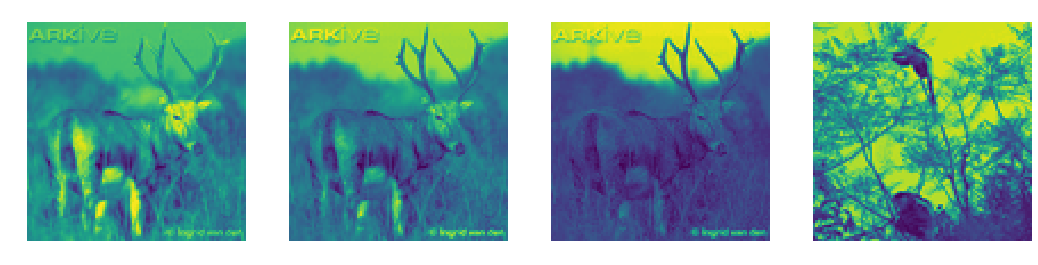

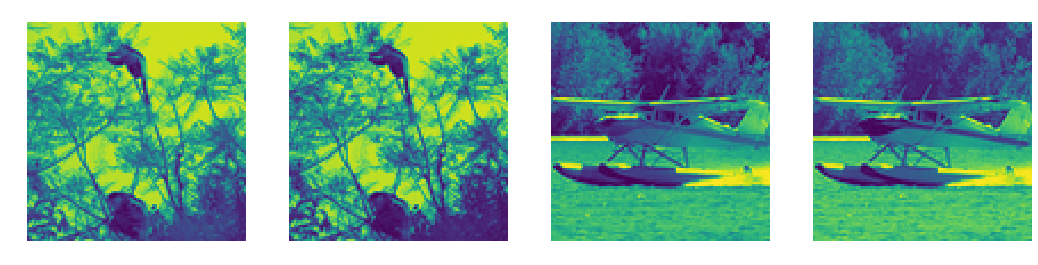

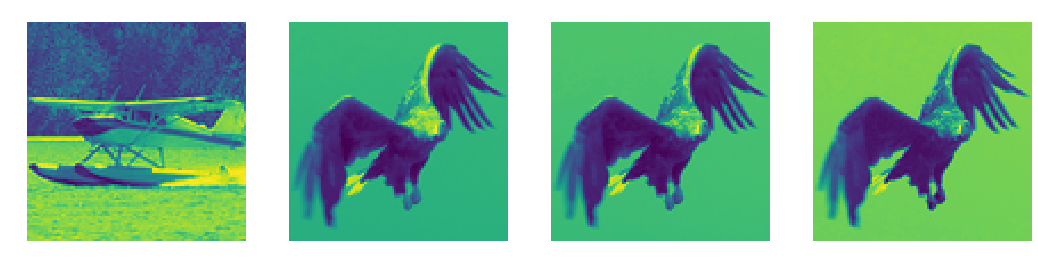

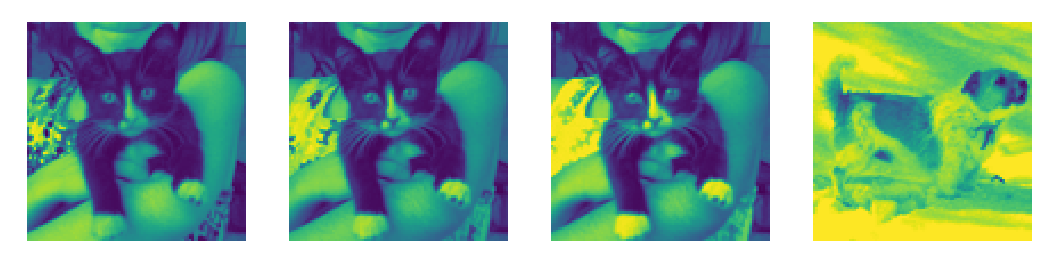

In [14]:
# Display last test batch

display_images(None, x, 4, count=True)

In [ ]:
# Choose starting and ending point for the interpolation -> shows original and reconstructed

A, B = 3, 8
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
display_images(None, torch.stack(((
    x[A].data.view(-1),
    x[B].data.view(-1),
    sample.data[0],
    sample.data[1]
)), 0))

In [ ]:
# Perform an interpolation between input A and B, in N steps

N = 16
code = torch.Tensor(N, 20).to(device)
for i in range(N):
    code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
sample = model.decoder(code)
display_images(None, sample, N // 4, count=True)